In [1]:
# Parameters
artificial_humans = {
    "full": {
        "contribution_model": "artifacts/behavioral_cloning/17_contribution_model_short_v3/model/architecture_node+edge+rnn__dataset_full.pt",
        "valid_model": "artifacts/behavioral_cloning/19_contribution_valid_model_v2/model/rnn_False__dataset_full.pt",
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt",
        "autoregressive": True,
    },
    "optimal": {
        "type": "rl",
        "path": "artifacts/manager/04_model/model/architecture_node+edge+rnn__run_0.pt",
    },
}

n_episode_steps = 16
n_episodes = 50
basedir = "../.."


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
import random
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'model_path': os.path.join(basedir, v['path'])} for k,v in managers.items()}
managers

{'humanlike': {'type': 'human',
  'path': 'artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt',
  'autoregressive': True,
  'model_path': '../../artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt'},
 'optimal': {'type': 'rl',
  'path': 'artifacts/manager/04_model/model/architecture_node+edge+rnn__run_0.pt',
  'model_path': '../../artifacts/manager/04_model/model/architecture_node+edge+rnn__run_0.pt'}}

In [3]:
import re
import requests
import datetime
import os
import random
import numpy as np


BACKEND_URL = os.environ.get('MANAGER_BACKEND_URL', 'http://0.0.0.0:5001')


def get_punishments(contributions, missing_inputs, groups, *, session, group_idx, round):
    """
    Requests the punishments form the manger backend.

    Args:
        contributions [int]: contributions in fixed order (order has to remain throughout the game)
        missing_inputs [boolean]: missing_inputs in fixed order (same order as contributions)
        groups [str]: group identifier in fixed order (same order as contributions)
        session str: session indentifier
        subsession str: subsession identifier
        round int: round number

    Returns:
        [int]: punishments for each player in the same order then contributions
    """
    data = {
        'contributions': contributions,
        'missing_inputs': missing_inputs,
        'groups': groups,
        'round': round,
        'group_idx': group_idx,
        'session': session,
        'datetime': str(datetime.datetime.now())
    }
    url = BACKEND_URL + '/get_punishments'
    response = requests.post(url, json={'data': data}).json()
    return response

In [4]:
def mem_to_df(recorder, name):
    columns = ['episode','participant_code','round_number']

    punishments = using_multiindex(recorder.memory['punishment'].squeeze(1).numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].squeeze(1).numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contribution'].squeeze(1).numpy(), columns=columns, value_name='contribution')
    api_punishments = using_multiindex(recorder.memory['api_punishments'].squeeze(1).numpy(), columns=columns, value_name='api_punishments')
    group = using_multiindex(recorder.memory['group'].squeeze(1).numpy(), columns=columns, value_name='group')

    df_sim = punishments.merge(common_good).merge(contributions).merge(group).merge(api_punishments)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, round, groups, episode_group_idx):
    return {
        'contribution': contributions,
        'contribution_valid': [c is not None for c in contributions],
        'punishment_valid': [False] * len(contributions),
        'punishment': [None] * len(contributions),
        'group': groups,
        'round': round,
        'episode_group_idx': episode_group_idx
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishment': punishments,
        'punishment_valid': [p is not None for p in punishments],
    }


In [5]:
device = th.device('cpu')
rec_device = th.device('cpu')

mm = MultiManager(managers)

# fix bug
for k, man  in mm.managers.items():
    if 'autoregressive' in managers[k]:
        man.model.autoregressive = managers[k]['autoregressive']

runs = {
    f"ah {h} managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

model_name_map = {
    'humanlike': 'humanlike_governor',
    'human': 'human',
    'optimal': 'ai_governor'
}


dfs = []
for name, run in runs.items():
    print(f'Start run {name}')

    random_session = str(random.randint(0, 1000000))

    groups = run['groups']
    n_agents = len(groups)

    hm_path = os.path.join(basedir, artificial_humans[run['humans']]['contribution_model'])
    hmv_path = os.path.join(basedir, artificial_humans[run['humans']]['valid_model'])

    ah = GraphNetwork.load(hm_path, device=device)
    ah_val = GraphNetwork.load(hmv_path, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        episode_group_idx = random.randint(0,1000000)
        rounds = []
        for round_number in count():
            contributions = state['contribution'].squeeze().tolist()
            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds+[round])[0]
            response = get_punishments(
                contributions, 
                [c is None for c in contributions], 
                [model_name_map[g] for g in groups], 
                session=random_session, 
                group_idx=episode_group_idx, 
                round=round_number)
            
            api_punishments = response['data']['punishments']

            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            api_punishments = th.tensor(api_punishments, dtype=th.int64).unsqueeze(-1).unsqueeze(0)
            state = env.punish(punishments.unsqueeze(-1).unsqueeze(0))
            recorder.add(
                **{k: v if len(v.shape) == 3 else v.unsqueeze(-1) for k, v in state.items()},
                api_punishments=api_punishments,
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah full managed by humanlike
Start run ah full managed by optimal


In [6]:
df = pd.concat(dfs).reset_index(drop=True)

df['api_punishment_delta'] = df['punishment'] - df['api_punishments']

df['episode'] = df['run'] + '__' + df['episode'].astype(str)

dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'api_punishments', 'api_punishment_delta', 'contribution', 'common_good'])

In [7]:
dfm[dfm['value'].isnull()]

,episode,round_number,participant_code,run,variable,value


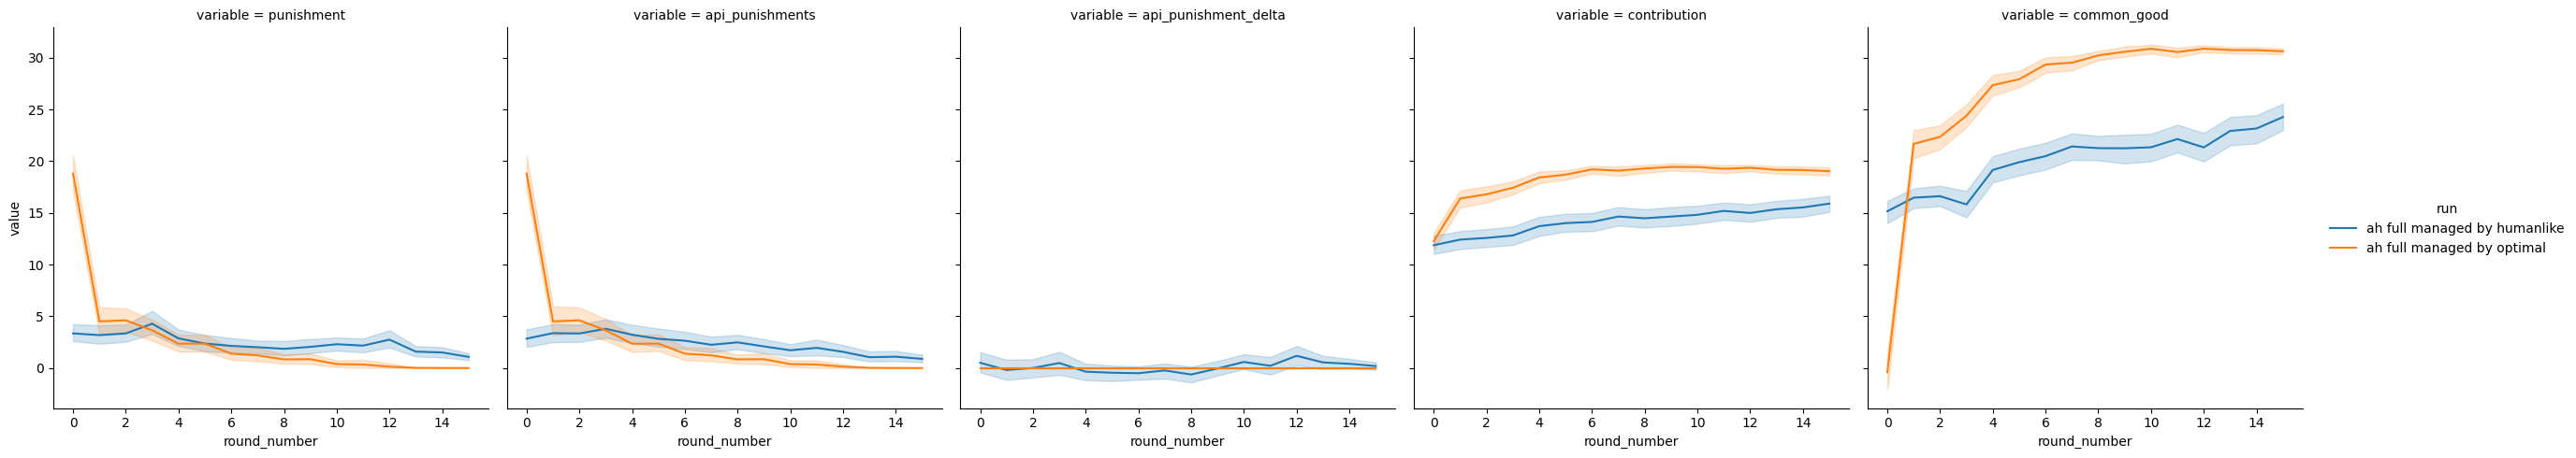

In [8]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line"
)